# Dataset profiling
Given the OBB dataset exported from Label-Studio, this notebook profiles the class distribution, OBB orientation and OBB center positions.

In [ ]:
import yaml
from collections import Counter
from matplotlib import gridspec
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import chi2

In [7]:
# Path to objects.yaml (YOLO format)
yaml_path = "data/in-bucket/objects.yaml"
# Split files produced from ultralytics autosplits
train_split = "data/in-bucket/autosplit_train.txt"
val_split = "data/in-bucket/autosplit_val.txt"

# Load class names from YAML
with open(yaml_path, "r") as f_yaml:
    data = yaml.safe_load(f_yaml)
names = data["names"]

# Simple label count
def count_labels(split_file):
    counter = Counter()
    with open(split_file, "r") as f:
        image_paths = [line.strip() for line in f.readlines()]

    for img_path in image_paths:
        label_path = img_path.replace("images", "labels").rsplit(".", 1)[0] + ".txt"
        label_path = "data/in-bucket" + label_path[1:]
        if os.path.exists(label_path):
            with open(label_path, "r") as lf:
                has_annot = False
                for line in lf:
                    cls = int(line.split()[0])
                    counter[cls] += 1
                    has_annot = True
                if not has_annot:
                    counter['background'] += 1
    return counter

train_counts = count_labels(train_split)
val_counts = count_labels(val_split)

# Output results
print("Train class distribution:")
for i, name in enumerate(names):
    print(f"{name:20s}: {train_counts[i]}")

print("\nValidation class distribution:")
for i, name in enumerate(names):
    print(f"{name:20s}: {val_counts[i]}")

Train class distribution:
Andrena             : 71
Anthidium           : 36
Apis                : 293
Bombus              : 195
Halictus            : 131
Hylaeus             : 20
Lasioglossum        : 81
Osmia               : 48
Syrphidae           : 130
Vespidae            : 121

Validation class distribution:
Andrena             : 36
Anthidium           : 23
Apis                : 126
Bombus              : 83
Halictus            : 53
Hylaeus             : 6
Lasioglossum        : 23
Osmia               : 19
Syrphidae           : 46
Vespidae            : 45


## OBB boxes
Extracts the center location of all OBB boxes and computes the orientation of the OBB boxes. OBB boxes in this dataset are set to point the front towards the anterior of the specimen.

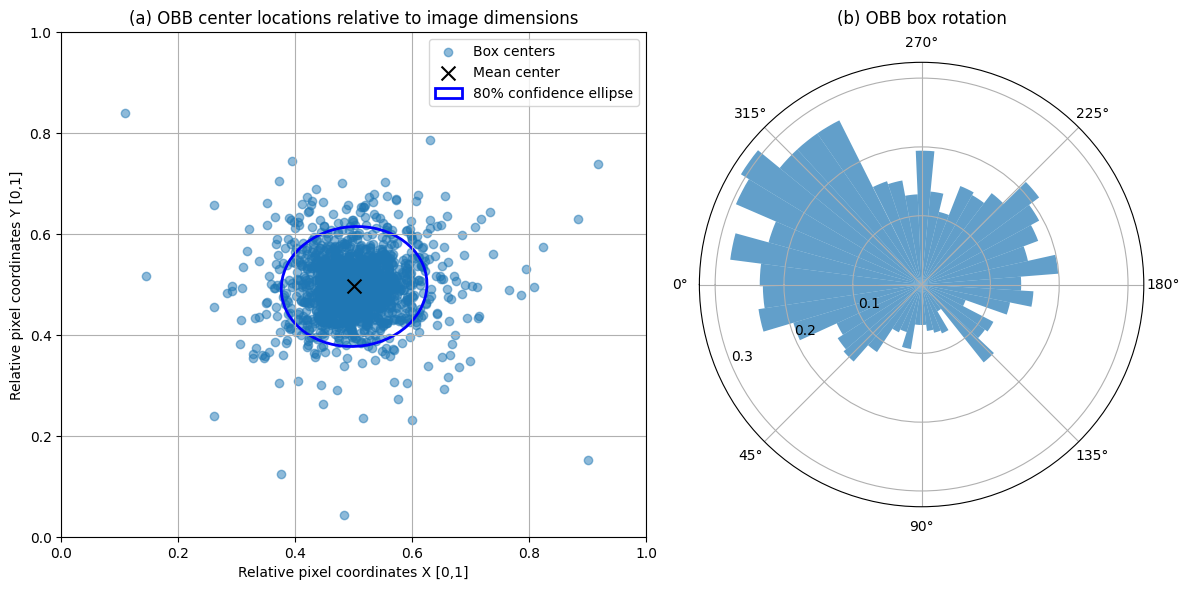

In [8]:
# Path to YOLO OBB labels
folder = "data/in-bucket/labels"

centers = []
angles = []

for fname in os.listdir(folder):
    if fname.endswith(".txt"):
        with open(os.path.join(folder, fname), "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 9:  # class + 4 corners
                    # Extract corner coordinates
                    x1, y1 = float(parts[1]), float(parts[2])
                    x2, y2 = float(parts[3]), float(parts[4])
                    x3, y3 = float(parts[5]), float(parts[6])
                    x4, y4 = float(parts[7]), float(parts[8])

                    # Compute center
                    cx = np.mean([x1, x2, x3, x4])
                    cy = np.mean([y1, y2, y3, y4])
                    centers.append((cx, 1 - cy))

                    # Compute angle (edge from corner 1 to corner 2)
                    angle = 90 - np.arctan2(y1 - y2, x1 - x2)
                    angles.append(angle)

centers = np.array(centers)
angles = np.array(angles)
avg_x, avg_y = centers.mean(axis=0)

def n_std_for_confidence(p):
    return np.sqrt(chi2.ppf(p, df=2))

def plot_confidence_ellipse(x, y, ax, p=0.75, **kwargs):
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    # chi test
    n_std = n_std_for_confidence(p)
    width, height = 2 * n_std * np.sqrt(vals)
    
    # Confidence ellipse
    ellipse = Ellipse(
        xy=(np.mean(x), np.mean(y)),
        width=width,
        height=height,
        angle=theta,
        **kwargs
    )
    ax.add_patch(ellipse)


fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,0.76])
# Cartesian subplot
ax1 = fig.add_subplot(gs[0])
ax1.scatter(centers[:, 0], centers[:, 1], alpha=0.5, label="Box centers")
ax1.scatter(avg_x, avg_y, color="black", s=100, marker="x", label="Mean center")
plot_confidence_ellipse(centers[:,0], centers[:,1], ax1,
                        p=0.8, edgecolor="blue", facecolor="none", lw=2, label="80% confidence ellipse")
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
ax1.set_xlabel("Relative pixel coordinates X [0,1]")
ax1.set_ylabel("Relative pixel coordinates Y [0,1]")
ax1.set_title("(a) OBB center locations relative to image dimensions")
ax1.legend()
ax1.grid(True)

# Polar subplot
ax2 = fig.add_subplot(gs[1], polar=True)
ax2.hist(angles, bins=45, density=True, alpha=0.7)
ax2.set_rticks([0.1, 0.2, 0.3])
ax2.set_theta_zero_location("W")
ax2.set_title("(b) OBB box rotation", va="bottom")

plt.tight_layout()
plt.show()
